Confirming Our Best Model

In [3]:
import numpy as np
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import  r2_score
from sklearn.model_selection import train_test_split
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

/home/pedro/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [4]:
# Load data
X_train_input = np.load("Data/X_train.npy")  # shape (700, 6)
Y_train_input = np.load("Data/Y_train.npy")  # shape (700,)

# Remove the second entry (index 1) 
X_train_input = np.delete(X_train_input, 1, axis=1)

print("New shapes:", X_train_input.shape, Y_train_input.shape)

# Random train/test split (200 for test, rest for training)
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train_input, Y_train_input, test_size=200, random_state=42, shuffle=True
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

New shapes: (700, 5) (700,)


In [5]:
# Hyperparameter grids - Specialized
gamma_list =  [0.13, 0.14, 0.15, 0.16, 0.17]
alpha_list = [0.0005, 0.001, 0.002, 0.003]

# K-Fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)

best_r2 = -np.inf
best_params = None
results = []

In [6]:
for gamma, alpha in product(gamma_list, alpha_list):
    
    r2_scores = []
    
    for train_idx, val_idx in kf.split(X_train_scaled):
        X_tr, X_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
        Y_tr, Y_val = Y_train[train_idx], Y_train[val_idx]
    
        # Train Ridge regression
        model = KernelRidge(kernel='rbf', gamma=gamma, alpha=alpha)
        model.fit(X_tr, Y_tr)
        
        # Predict on validation fold
        Y_val_pred = model.predict(X_val)
        r2_scores.append(r2_score(Y_val, Y_val_pred))
    
    mean_r2 = np.mean(r2_scores)
    results.append({'gamma': gamma, 'alpha': alpha, 'mean_r2': mean_r2})
    
    if mean_r2 > best_r2:
        best_r2 = mean_r2
        best_params = {'gamma': gamma, 'alpha': alpha}

print("Best Cross Validation R2:", best_r2)
print("Best Hyperparameters:", best_params)

Best Cross Validation R2: 0.9933042038559551
Best Hyperparameters: {'gamma': 0.14, 'alpha': 0.002}


In [7]:
# Refit model on all 500 training samples using best hyperparameters
gamma_best = best_params['gamma']
alpha_best = best_params['alpha']

# Train final model
final_model = KernelRidge(kernel='rbf', gamma=gamma_best, alpha=alpha_best)
final_model.fit(X_train_scaled, Y_train)

# Predict on held-out 200 samples
Y_test_pred = final_model.predict(X_test_scaled)
test_r2 = r2_score(Y_test, Y_test_pred)
print("R2 on held-out 200 test samples:", test_r2)

R2 on held-out 200 test samples: 0.9915600334455307


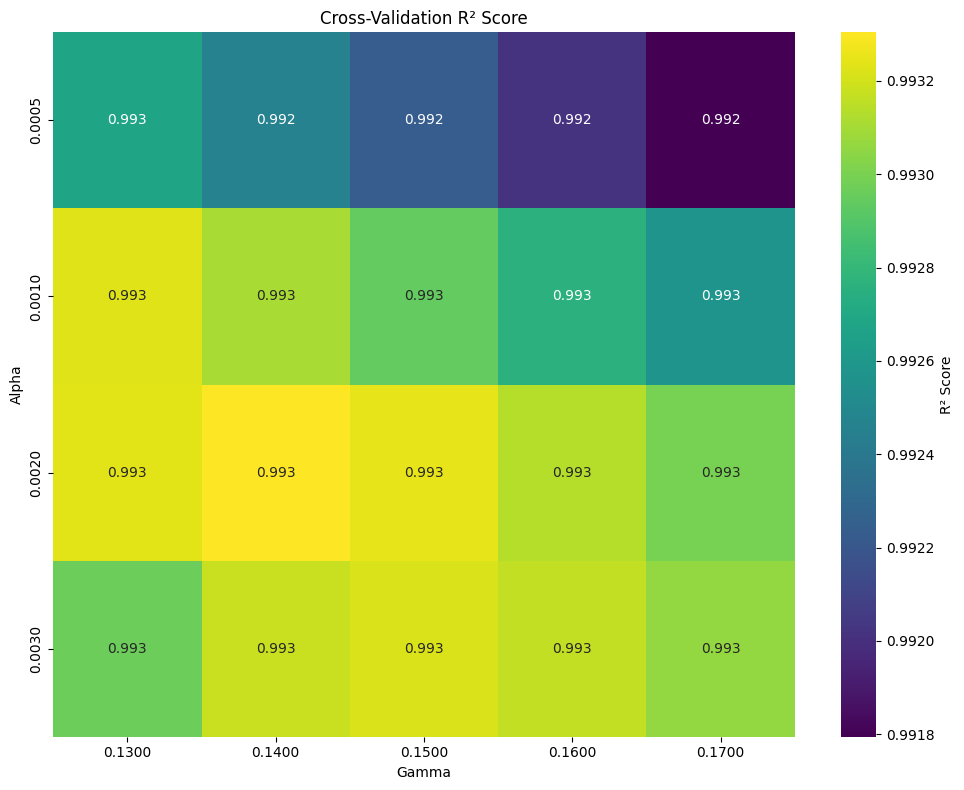

In [8]:
# Convert results to 2D array for heatmap
gamma_vals = sorted(list(set(r['gamma'] for r in results)))
alpha_vals = sorted(list(set(r['alpha'] for r in results)))

# Create heatmap data
heatmap_data = np.zeros((len(alpha_vals), len(gamma_vals)))

for i, alpha in enumerate(alpha_vals):
    for j, gamma in enumerate(gamma_vals):
        # Find corresponding mean_r2
        for r in results:
            if r['gamma'] == gamma and r['alpha'] == alpha:
                heatmap_data[i, j] = r['mean_r2']
                break

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, 
            annot=True, 
            fmt=".3f", 
            xticklabels=[f"{g:.4f}" for g in gamma_vals],
            yticklabels=[f"{a:.4f}" for a in alpha_vals],
            cmap="viridis",
            cbar_kws={'label': 'R² Score'})
plt.title("Cross-Validation R² Score")
plt.xlabel("Gamma")
plt.ylabel("Alpha")
plt.tight_layout()
plt.show()

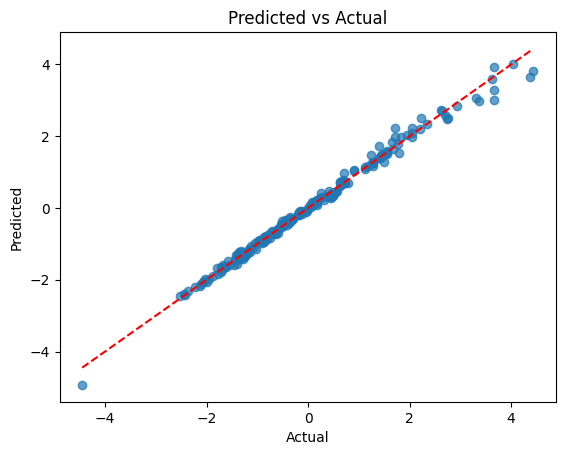

In [9]:
plt.scatter(Y_test, Y_test_pred, alpha=0.7)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual")
plt.show()


In [10]:
from sklearn.model_selection import cross_val_score
import numpy as np

cv_scores = cross_val_score(final_model, X_train_scaled, Y_train, cv=5, scoring='r2')
print("CV R2 scores:", cv_scores)
print("Mean CV R2:", np.mean(cv_scores))


CV R2 scores: [0.99485537 0.99333105 0.99523798 0.99218973 0.99440034]
Mean CV R2: 0.9940028956955975


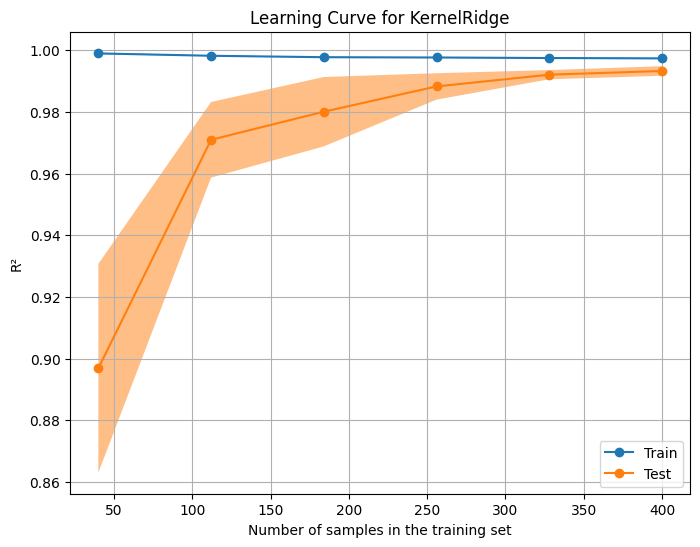

In [11]:
from sklearn.model_selection import LearningCurveDisplay

# Plot learning curve using the same CV (kf) you used for hyperparameter tuning
fig, ax = plt.subplots(figsize=(8,6))

LearningCurveDisplay.from_estimator(
    estimator=final_model,
    X=X_train_scaled,
    y=Y_train,
    cv=kf,
    train_sizes=np.linspace(0.1, 1.0, 6),
    score_type='both',
    n_jobs=-1,
    line_kw={"marker": "o"},
    std_display_style="fill_between",
    score_name="R²",
    ax=ax
)

ax.set_title("Learning Curve for KernelRidge")
ax.grid(True)
plt.show()


In [12]:
from sklearn.model_selection import permutation_test_score

score, perm_scores, pvalue = permutation_test_score(
    final_model, X_test_scaled, Y_test, scoring="r2", cv=5, n_permutations=100, random_state=42
)
print("Permutation test R2:", score)
print("p-value:", pvalue)

Permutation test R2: 0.9780658475782216
p-value: 0.009900990099009901


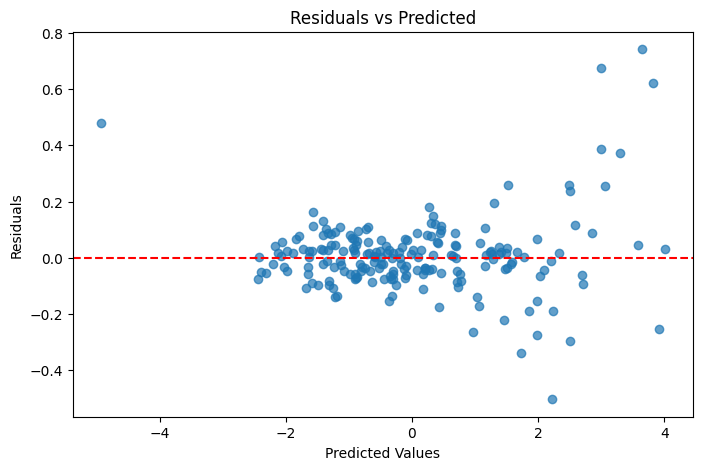

In [13]:
import matplotlib.pyplot as plt

residuals = Y_test - Y_test_pred
plt.figure(figsize=(8, 5))
plt.scatter(Y_test_pred, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.show()